In [262]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

Проанализовать предметную область и выбрать метрику оценки качества кластеризации

In [263]:
df = pd.read_csv('Chemical Composion of Ceramic.csv')
df.head()

,Ceramic Name,Part,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5
0,FLQ-1-b,Body,0.62,0.38,19.61,71.99,4.84,0.31,0.07,1.18,630,10,70,10,430,0,40,80,90
1,FLQ-2-b,Body,0.57,0.47,21.19,70.09,4.98,0.49,0.09,1.12,380,20,80,40,430,-10,40,100,110
2,FLQ-3-b,Body,0.49,0.19,18.60,74.70,3.47,0.43,0.06,1.07,420,20,50,50,380,40,40,80,200
3,FLQ-4-b,Body,0.89,0.30,18.01,74.19,4.01,0.27,0.09,1.23,460,20,70,60,380,10,40,70,210
4,FLQ-5-b,Body,0.03,0.36,18.41,73.99,4.33,0.65,0.05,1.19,380,40,90,40,360,10,30,80,150


Отобрать признаки

In [264]:
features = df.columns[2:]
df_features = df[features]

In [265]:
df_features.head()

,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5
0,0.62,0.38,19.61,71.99,4.84,0.31,0.07,1.18,630,10,70,10,430,0,40,80,90
1,0.57,0.47,21.19,70.09,4.98,0.49,0.09,1.12,380,20,80,40,430,-10,40,100,110
2,0.49,0.19,18.60,74.70,3.47,0.43,0.06,1.07,420,20,50,50,380,40,40,80,200
3,0.89,0.30,18.01,74.19,4.01,0.27,0.09,1.23,460,20,70,60,380,10,40,70,210
4,0.03,0.36,18.41,73.99,4.33,0.65,0.05,1.19,380,40,90,40,360,10,30,80,150


In [266]:
df_features.shape

(88, 17)


Реализовать алгоритмы k-menas++ и DBSCAN


In [267]:
class KMeans_PP:
    def __init__(self, data: pd.DataFrame | np.ndarray):
        if isinstance(data, pd.DataFrame):
            data = data.to_numpy()
        self.data = data
        self.n_samples, self.n_features = self.data.shape
    
    def euclidean_distance(self, a, b):
        return np.linalg.norm(a - b, axis=1)

    def init_centroids(self, k):
        # Выбор первого центроида случайным образом
        self.centroids = [self.data[np.random.choice(self.n_samples)]]
        
        # Выбор остальных центроидов
        for _ in range(1, k):
            # Вычисляем расстояния от каждой точки до ближайшего центроида
            distances = np.array([min(self.euclidean_distance(x, np.array(self.centroids))) for x in self.data])
            
            # Вычисляем вероятности
            prob = distances / distances.sum()
            
            # Убедимся, что prob одномерный
            if prob.ndim > 1:
                prob = prob.flatten()
            
            # Выбираем следующий центроид
            next_centroid = self.data[np.random.choice(self.n_samples, p=prob)]
            self.centroids.append(next_centroid)
        
        self.centroids = np.array(self.centroids)
    
    def standart_k_mean(self, k, max_iters):
        for _ in range(max_iters):
            # Назначение кластеров
            distances = np.array([self.euclidean_distance(self.data, centroid) for centroid in self.centroids])
            labels = np.argmin(distances, axis=0)
            
            # Обновление центроидов
            new_centroids = np.array([self.data[labels == i].mean(axis=0) for i in range(k)])
            
            # Проверка на сходимость
            if np.all(self.centroids == new_centroids):
                break
            self.centroids = new_centroids
        
        return labels, self.centroids
    
    def learn(self, k, max_iters=100):
        self.init_centroids(k)
        return self.standart_k_mean(k, max_iters)

# Пример использования
# df_features = pd.DataFrame(np.random.rand(100, 2))  # Пример данных
kmpp = KMeans_PP(df_features)
k = 5
max_iters = 10
labels, centroids = kmpp.learn(k, max_iters)
print("Labels:", labels)
print("Centroids:", centroids)

Labels: [3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 1 2 1 2 2 2 0 2 1 2 1 1 1 4 4 2 0 2 4 2 0 0 0 2 4 4 2 4 0 4
 0 0 0 4 2 4 2 4 4 0 4 0 2 0]
Centroids: [[4.25000000e-01 4.65833333e-01 1.33075000e+01 7.17008333e+01
  5.13500000e+00 6.89416667e+00 7.33333333e-02 1.00083333e+00
  9.36666667e+02 3.16666667e+01 9.75000000e+01 2.41666667e+01
  2.51666667e+02 5.15833333e+02 3.41666667e+01 1.32500000e+02
  5.73333333e+02]
 [1.10428571e+00 3.51428571e-01 1.40014286e+01 7.10285714e+01
  4.86142857e+00 6.07714286e+00 8.28571429e-02 1.49142857e+00
  6.25714286e+02 2.71428571e+01 5.85714286e+01 2.57142857e+01
  3.41428571e+02 1.52857143e+02 3.14285714e+01 7.71428571e+01
  4.64285714e+02]
 [5.16428571e-01 5.15714286e-01 1.31464286e+01 6.90678571e+01
  4.73142857e+00 9.57214286e+00 8.57142857e-02 1.36857143e+00
  1.06000000e+03 3.21428571e+01 7.85714286e+01 2.28571429e+01
  2.67857143e+02 4.13571429e+02 3.57142857e+01 1.12857143e+02
  1.01000000e+03]
 [3

In [268]:
class DBScan:
    def __init__(self, data: pd.DataFrame | np.ndarray):
        if isinstance(data, pd.DataFrame):
            data = data.to_numpy()
        self.data = data
        self.n_samples, self.n_features = self.data.shape
    
    def euclidean_distance(self, a, b):
        return np.linalg.norm(a - b, axis=1)
    
    def dbscan(self, eps, min_samples):
        labels = np.full(self.n_samples, -1)  # -1 означает шум
        cluster_id = 0
        
        for i in range(self.n_samples):
            if labels[i] != -1:  # Пропустить уже обработанные точки
                continue
            
            # Найти соседей
            distances = self.euclidean_distance(self.data[i], self.data)
            neighbors = np.where(distances < eps)[0]
            
            if len(neighbors) < min_samples:  # Шум
                labels[i] = -1
            else:  # Новая кластер
                labels[i] = cluster_id
                self.expand_cluster(labels, neighbors, cluster_id, eps, min_samples)
                cluster_id += 1
        
        return labels

    def expand_cluster(self, labels, neighbors, cluster_id, eps, min_samples):
        i = 0
        while i < len(neighbors):
            neighbor_index = neighbors[i]
            
            if labels[neighbor_index] == -1:  # Если точка ещё не обработана
                labels[neighbor_index] = cluster_id
                
                # Найти соседей новой точки
                new_distances = self.euclidean_distance(self.data[neighbor_index], self.data)
                new_neighbors = np.where(new_distances < eps)[0]
                
                if len(new_neighbors) >= min_samples:  # Если точка тоже ядро
                    neighbors = np.concatenate((neighbors, new_neighbors))
            
            i += 1

dbs = DBScan(df_features)
eps = 200
min_samples = 2
labels = dbs.dbscan(eps, min_samples)
print("Labels:", labels)

scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

dbs = DBScan(df_features_scaled)
eps_scaled = 1.5
labels_scaled = dbs.dbscan(eps, min_samples)
print()
print("Labels:", labels)

Labels: [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  1  2
 -1  2 -1 -1 -1  2  1  1  1  3 -1  4  5  4  3  4  5 -1  6 -1 -1  7  4 -1
  8 -1  6  6 -1 -1 -1 -1 -1 -1 -1  8  7  6 -1  6]

Labels: [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  1  2
 -1  2 -1 -1 -1  2  1  1  1  3 -1  4  5  4  3  4  5 -1  6 -1 -1  7  4 -1
  8 -1  6  6 -1 -1 -1 -1 -1 -1 -1  8  7  6 -1  6]


почему такие eps? та вот почему...

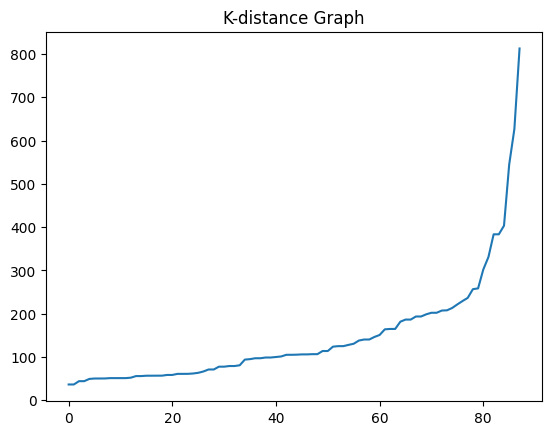

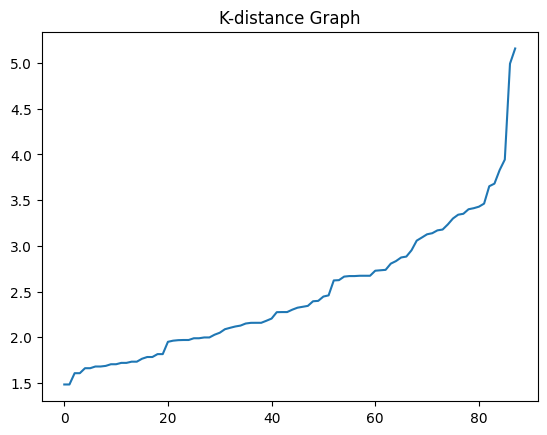

In [269]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_features)
distances, indices = nbrs.kneighbors(df_features)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.title("K-distance Graph")
plt.show()

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_features_scaled)
distances, indices = nbrs.kneighbors(df_features_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.title("K-distance Graph")
plt.show()


Проверить качество кластеризации по выбранной метрике

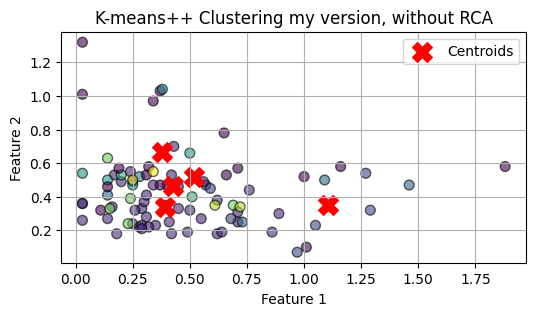

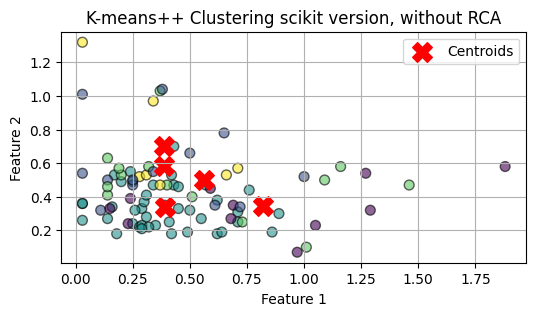

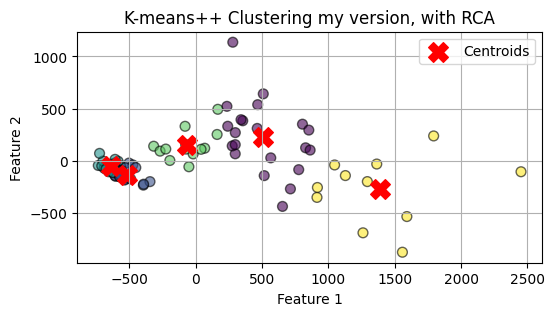

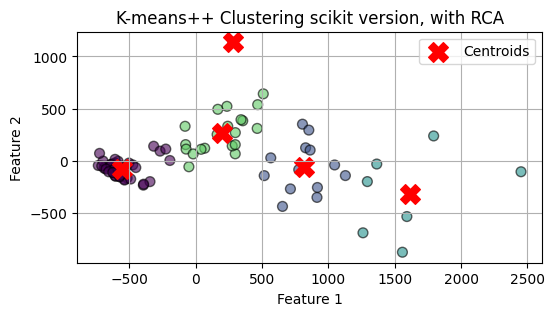

In [ ]:
def plot_clusters_kmpp(data, labels, centroids, add_title = ""):
    plt.figure(figsize=(6, 3))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6, edgecolor='k')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    plt.title("K-means++ Clustering" + add_title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_clusters_kmpp(kmpp.data, labels, centroids, " my version, without RCA")

sk_kmpp = KMeans(n_clusters=k, init='k-means++')
sk_kmpp.fit(kmpp.data)
labels = sk_kmpp.labels_
centroids = sk_kmpp.cluster_centers_
plot_clusters_kmpp(df_features.to_numpy(), labels, centroids, " scikit version, without RCA")

pca = PCA(n_components=2)
data_2d = pca.fit_transform(kmpp.data)
kmpp = KMeans_PP(data_2d)
labels, centroids = kmpp.learn(k, max_iters)
plot_clusters_kmpp(kmpp.data, labels, centroids, " my version, with RCA")


sk_kmpp = KMeans(n_clusters=k, init='k-means++')
sk_kmpp.fit(kmpp.data)
labels = sk_kmpp.labels_
centroids = sk_kmpp.cluster_centers_
plot_clusters_kmpp(data_2d, labels, centroids, " scikit version, with PCA")

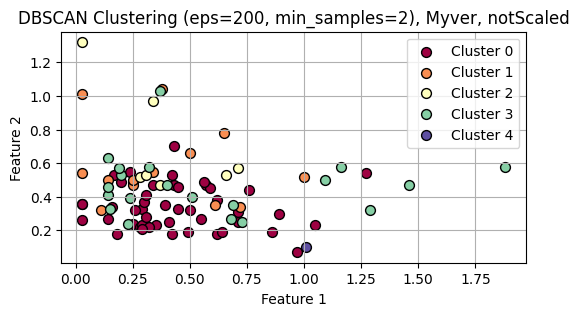

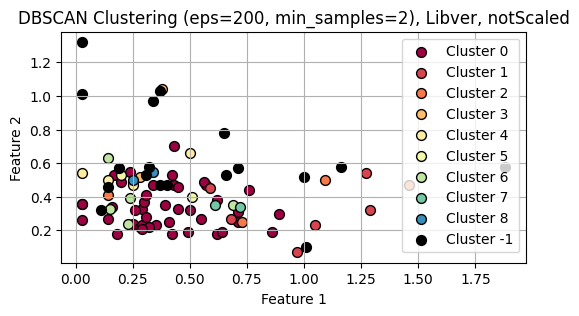

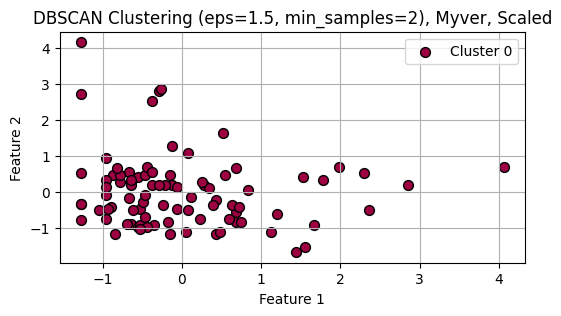

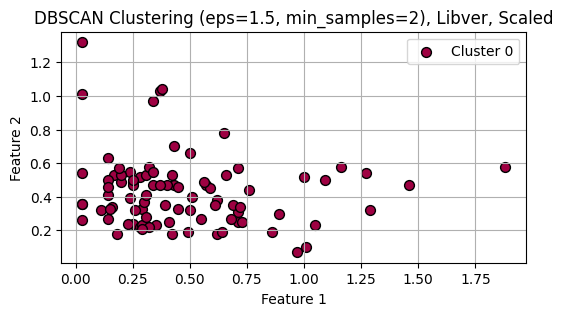

In [271]:
def plot_dbscan_clusters(data, labels, eps, min_samples, additional_title):
    plt.figure(figsize=(6, 3))
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]  # Шум (чёрный цвет)
        
        class_member_mask = (labels == k)
        xy = data[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c=[col], s=50, edgecolor='k', label=f'Cluster {k}')
    
    plt.title(f"DBSCAN Clustering (eps={eps}, min_samples={min_samples}), {additional_title}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_dbscan_clusters(df_features.to_numpy(), labels, eps, min_samples, "Myver, notScaled")
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
scikit_labels = dbscan.fit_predict(df_features.to_numpy())
plot_dbscan_clusters(df_features.to_numpy(), scikit_labels, eps, min_samples, "Libver, notScaled")
plot_dbscan_clusters(df_features_scaled, labels_scaled, eps_scaled, min_samples, "Myver, Scaled")
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
scikit_labels = dbscan.fit_predict(df_features_scaled)
plot_dbscan_clusters(df_features.to_numpy(), scikit_labels, eps_scaled, min_samples,"Libver, Scaled")

че делает стандарт скаляр? он делает так чтобы среднее было 0, а отклонение было в 1.

зачем надо? базово, для нейронки (в данном случае, для метода МО) все эти value*10^N, при n >=1, слишком большие и оно не понимает как с ними корректно работать, поэтому, по хорошему, надо сделать так, чтобы числа были в минимальном масштабе (мы юзали в баке значения от -1 до 1). 

Стандарт скейлер как раз это и делает:

1. считает среднее = mean
2. считает отклонение omega = (корень из 1/n* E(n, i=1)[xi - mean]^2)
3. стандартизирует - x_standart = (xi-mean)/omega

че делает RCA? уменьшает размерность данных, в зависимости от компонент
1. гоняет стандартизатор, например стандартскаляр
2. считает матричку, Х - набор данных, где строка - объект, а столбец признак по формуле, C = 1/n * XT*X
3. высчитываются собственные значения и собственные векторы - Cv = lambda*v 
    1. лямбда, в данном случае - корень уравнения det(C-lambda*E) = 0
    2. v-же получаются с помощью уравнения (C-lambdaE)*v = 0 (тут получается СЛУ, решаем относительно v)
4. получаем RCA данные - Xrca = X*V, где V - матрица собственных векторов
